# NNMF with cross-validated number of components

INFO:


TODO:
- plot repeated nnmf_cv results and find cutoff at CI95

In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' # limit env var for multithreading > avoids numpy-vs-multiprocessing conflict (do before numpy import)

In [2]:
# Library/module setup

import sys
sys.path.append('./ext/') # Import path to external code

from cv import * # NNMF cross-validation functions

import glob # file browsing
from scipy import stats
import scipy.io as sio # data input/output

import multiprocessing # parallel computing

import time # timing computations
import datetime
import logging # log outputs allows to disconnect from notebook

# %matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
# Load PSTH data (.mat file)
orig_data = sio.loadmat('../data/nnmf_best.mat')
sio.whosmat('../data/nnmf_best.mat')

[('A', (641, 25), 'double'),
 ('D_res', (100, 1), 'double'),
 ('X', (641, 815), 'double'),
 ('Y', (25, 815), 'double'),
 ('k_best', (1, 1), 'double'),
 ('psth', (1, 1), 'struct')]

In [4]:
# Extract PSTH data
data = orig_data['psth']['psth'][0,0] # PSTH array is in nnmf_best.psth.psth
print('data: firing rate PSTH of %i cells x %i tPoints' % data.shape)

data: firing rate PSTH of 815 cells x 641 tPoints


# Parameters

In [5]:
# Analysis pars
do_model = False # run the cv nnmf model to get training and test error per rank
do_assemble = False # run data assembler
do_opt_model = True # run optimal model to find actual NNMF components

# Fit NNMF model

In [6]:
# Parameters
ranks = [[x] for x in range(1,71)] # range of components to test (NOTE: range(1,11) = ranks 1-10)
repetitions = range(51,61) # number of repetitions; given as range to control repetition_ID (used for rng)
iterator = [(i[0],j) for (i,j) in itertools.product(ranks, repetitions)]

In [7]:
iterator

[(1, 51),
 (1, 52),
 (1, 53),
 (1, 54),
 (1, 55),
 (1, 56),
 (1, 57),
 (1, 58),
 (1, 59),
 (1, 60),
 (2, 51),
 (2, 52),
 (2, 53),
 (2, 54),
 (2, 55),
 (2, 56),
 (2, 57),
 (2, 58),
 (2, 59),
 (2, 60),
 (3, 51),
 (3, 52),
 (3, 53),
 (3, 54),
 (3, 55),
 (3, 56),
 (3, 57),
 (3, 58),
 (3, 59),
 (3, 60),
 (4, 51),
 (4, 52),
 (4, 53),
 (4, 54),
 (4, 55),
 (4, 56),
 (4, 57),
 (4, 58),
 (4, 59),
 (4, 60),
 (5, 51),
 (5, 52),
 (5, 53),
 (5, 54),
 (5, 55),
 (5, 56),
 (5, 57),
 (5, 58),
 (5, 59),
 (5, 60),
 (6, 51),
 (6, 52),
 (6, 53),
 (6, 54),
 (6, 55),
 (6, 56),
 (6, 57),
 (6, 58),
 (6, 59),
 (6, 60),
 (7, 51),
 (7, 52),
 (7, 53),
 (7, 54),
 (7, 55),
 (7, 56),
 (7, 57),
 (7, 58),
 (7, 59),
 (7, 60),
 (8, 51),
 (8, 52),
 (8, 53),
 (8, 54),
 (8, 55),
 (8, 56),
 (8, 57),
 (8, 58),
 (8, 59),
 (8, 60),
 (9, 51),
 (9, 52),
 (9, 53),
 (9, 54),
 (9, 55),
 (9, 56),
 (9, 57),
 (9, 58),
 (9, 59),
 (9, 60),
 (10, 51),
 (10, 52),
 (10, 53),
 (10, 54),
 (10, 55),
 (10, 56),
 (10, 57),
 (10, 58),
 (10, 59),
 

In [13]:
fname = ('logfile_%i-%i_%i-%i' % (ranks[0][0], ranks[-1][0], repetitions[0], repetitions[-1]))
fname

'logfile_1-70_51-60'

In [8]:
def nnmf_parallel(rank, repetition, data=data):
    
    ## Set random number generator seed 
    # This is necessary to get different results from multiprocessing.
    # One method is to set the seed to current time. Here, we convert sub-second values to int, because 
    # otherwise, parallel processes starting within the same second will have the same seed.
#     seed = int(str(time.time()).split(".")[1])
    # Another method to easily set reproducible seeds per rank and repetition is this one:
    seed = int(''.join((str(rank), str(repetition)))) # set reproducible seed
    np.random.seed(seed=seed)    

    # Write log
    print('  Fitting model:   rank: %i, repetition: %i, seed: %i ...' % (rank, repetition, seed))
    logging.info('  Fitting model:   rank: %i, repetition: %i, seed: %i ...' % (rank, repetition, seed))
    
    # Run model
    train_err, test_err = cv_pca(data, rank, M=None, p_holdout=0.3, nonneg=True)[2:]    
        
    return (rank, train_err, test_err, seed)

In [9]:
## Run nnmf_parallel() in parallel
if do_model:
    # Pars
    n_processes = multiprocessing.cpu_count()-4 # define number of kernels

    # Write log
    fname = ('logfile_%i-%i_%i-%i' % (ranks[0][0], ranks[-1][0], repetitions[0], repetitions[-1]))
    logging.basicConfig(level=logging.DEBUG, filename=fname, filemode="a+",
                        format="%(asctime)-15s %(levelname)-8s %(message)s")
    print('Fitting model for ranks %i-%i with repetition %i-%i.' \
          % (np.min(ranks), np.max(ranks), repetitions[0], repetitions[-1]))
    logging.info('Fitting model for ranks %i-%i with %i repetition(s).' \
          % (np.min(ranks), np.max(ranks), repetitions[-1]-repetitions[0]+1))

    # Split per repetition and rank for now to run code in chunks during debug 
    # NOTE: remove once runtime problems are resolved
    t = time.time()
    for rep in repetitions:
        chunk_size = 20 # ranke chunk size
        ranks_chunk = [ranks[i:i+chunk_size] for i in range(0,len(ranks), chunk_size)] # split into rank chunks
        for rnk in range(len(ranks_chunk)):        

            tt = time.time()
            train_err, test_err, seeds, temp, nnmf_cv_err_per_comp = [], [], [], None, None # initialize vars

            iterator = [(i[0],j) for (i,j) in itertools.product(ranks_chunk[rnk], range(rep,rep+1))]

            # Fit NNMF model (parallel implementation)
            print('Running parallelization with %i processes.' % n_processes)
            with multiprocessing.Pool(processes=n_processes) as pool:
                temp = pool.starmap(nnmf_parallel, iterator)

            train_err = [(i[0], i[1]) for i in temp]
            test_err = [(i[0], i[2]) for i in temp]
            seeds = [(i[3]) for i in temp]

            dur = round(time.time() - tt)
            print('DONE repetition %i, ranks %i-%i! Execution time: %s (h:min:sec).' 
                  % (rep, ranks_chunk[rnk][0][0], ranks_chunk[rnk][-1][0], str(datetime.timedelta(seconds=dur))))
            logging.info('DONE! Execution time: %s (h:min:sec).' % str(datetime.timedelta(seconds=dur)))

            # Save results
            do_save = True
            if do_save:
                nnmf_cv_err_per_comp = {'train_err': train_err, 'test_err': test_err, 'seeds': seeds}
                fname = ('../data/nnmf_cv_err_per_comp_%i-%i_%i-%i' 
                         % (np.min([j[0] for j in iterator]), np.max([j[0] for j in iterator]),
                            np.min([j[1] for j in iterator]), np.max([j[1] for j in iterator])))
                print('Saving file %s' %fname)
                np.save(fname, nnmf_cv_err_per_comp)

    dur = round(time.time() - t)            
    print('DONE for ranks %i-%i with repetition %i-%i. Execution time: %s (h:min:sec).' \
          % (np.min(ranks), np.max(ranks), repetitions[0], repetitions[-1], dur))
    logging.info('DONE for ranks %i-%i with repetition %i-%i. Execution time: %s (h:min:sec).(s).' \
          % (np.min(ranks), np.max(ranks), repetitions[-1]-repetitions[0]+1, dur))            

# Data assembler
Due to the analysis duration, the analysis results were continuously saved to files in chunks and need to be reassembled here

In [10]:
# Pars
if do_assemble:
    # Find all matching files
    file_list = glob.glob('../data/nnmf_cv_err_per_comp_*')
    print('Files found:')
    print(*file_list, sep='\n')

    test_err, train_err, seeds = [], [], [] # initialize vars

    # Assemble data from all files
    for f in file_list:
        print('Loading %s' % f)
        dat = np.load(f).item()

        # Add data to list
        test_err.extend(dat['test_err'])
        train_err.extend(dat['train_err'])
        seeds.extend(dat['seeds'])

    # Remove duplicates
    tr, te, s = [], [], []
    for idx,val in enumerate(test_err):
        if val not in te:
            te.append(val), tr.append(train_err[idx]), s.append(seeds[idx])
    print("Removing %i duplicates." % (len(test_err) - len(te)))
    train_err, test_err, seeds = tr, te, s
    print('Saving %i data points.' % len(train_err))    

    # Save summary file
    do_save = True
    if do_save:
        nnmf_cv_err_per_comp = {'train_err': train_err, 'test_err': test_err, 'seeds': seeds}
        fname = '../data/nnmf_cv_err_per_comp-all'
        print('Saving data summary file: %s' % fname)
        np.save(fname, nnmf_cv_err_per_comp)

In [11]:
# Load cross-validated NNMF errors per rank
# del nnmf_cv_err_per_comp
if ('nnmf_cv_err_per_comp' in locals() or 'nnmf_cv_err_per_comp' in globals()): # check if data already in workspace
    test_err  = nnmf_cv_err_per_comp['test_err']
    train_err = nnmf_cv_err_per_comp['train_err']
    seeds     = nnmf_cv_err_per_comp['seeds']
else: # else load it
    dat       = np.load('../data/nnmf_cv_err_per_comp-all.npy').item()
    test_err  = dat['test_err']
    train_err = dat['train_err']
    seeds     = dat['seeds']

print(len(train_err), len(test_err), len(seeds))

14012 14012 14012


# Find optimal number of ranks and find optimal seed

In [12]:
# OLD
def nnmf_statistics(errs, print_info=False):
    """nnmf_statistics(errs,  print_info=False):
    Calculate some statistics on cross-validated NNMF MSE results, used in plot_nnmf_cv_err().
    Argument: 
        errs: Error statistic and associated rank; tuple: (rank, error)
    Returns: 
        err, rank, mean_err, sd_err, N, ci_err, min_err, min_err_mean
    """

    err, rank = np.array([i[1] for i in errs]), np.array([i[0] for i in errs])
    ranks = np.unique(np.unique([i[0] for i in errs]))

    # Mean, SD, CI
    mean_err, sd_err = [np.mean(err[rnk==rank]) for rnk in ranks], [np.std(err[rnk==rank]) for rnk in ranks]
    N = [len(err[rnk==rank]) for rnk in ranks]
    ci_err    = stats.t.interval(0.95, df=N, loc=mean_err, scale = sd_err/np.sqrt(N))
    #     ci_train_norm = stats.norm.interval(0.95, loc=mean_train, scale = sd_train/np.sqrt(N))

    # Find rank / number of components with smallest MSE
    min_err = errs[np.argmin([x[1] for x in errs])] # min(MSE) single data point
    min_err_mean = (idx, val) = np.argmin(mean_err)+1, np.min(mean_err) # min(mean_MSE)
    
    if print_info:
        print('Number of components with single minimal MSE: %i (MSE: %f)' % (min_err[0], min_err[1]))
        print('Number of components with mean minimal MSE: %i (MSE: %f)' % (min_err_mean[0], min_err_mean[1]))

    return err, rank, ranks, mean_err, sd_err, N, ci_err, min_err, min_err_mean

In [34]:
def nnmf_statistics(errs, print_info=False):
    """nnmf_statistics(errs,  print_info=False):
    Calculate some statistics on cross-validated NNMF MSE results, used in plot_nnmf_cv_err().
    Argument: 
        errs: Error statistic and associated rank; tuple: (rank, error)
    Returns: 
        dict(err, rank, mean_err, sd_err, N, sem, ci_err, min_err, min_err_mean)
    """

    err, rank = np.array([i[1] for i in errs]), np.array([i[0] for i in errs])
    ranks = np.unique(np.unique([i[0] for i in errs]))

    # Mean, SD, CI
    mean_err, sd_err = [np.mean(err[rnk==rank]) for rnk in ranks], [np.std(err[rnk==rank]) for rnk in ranks]
    n = [len(err[rnk==rank]) for rnk in ranks]
    sem = sd_err/np.sqrt(n)
    ci_err    = stats.t.interval(0.95, df=n, loc=mean_err, scale = sem)
    #     ci_train_norm = stats.norm.interval(0.95, loc=mean_train, scale = sd_train/np.sqrt(N))

    # Find rank / number of components with smallest MSE
    min_err = errs[np.argmin([x[1] for x in errs])] # min(MSE) single data point
    min_err_mean = (idx, val) = np.argmin(mean_err), np.min(mean_err) # min(mean_MSE)
    
    if print_info:
        print('Number of components with single minimal MSE: %i (MSE: %f)' % (min_err[0]+1, min_err[1])) # (min_err[0]+1 due to 0-indexing
        print('Number of components with mean minimal MSE: %i (MSE: %f)' % (min_err_mean[0]+1, min_err_mean[1]))

        
    # Find lowest rank model within 1SE of minMSE rank
    min_err_mean_sem = sem[min_err_mean[0]] # Find SEM of rank with lowest MSE
    within_1SE = mean_err[:min_err_mean[0]] >= min_err_mean[1] + min_err_mean_sem # Find ranks within 1 SE of min err
    idx_within_1SE = [i for i, x in enumerate(within_1SE) if not x] # Find rank indices within 1 SE
    if idx_within_1SE:
        idx_min_err_mean_1SE = idx_within_1SE[0] # Use smallest rank within 1SE
        min_err_mean_1SE = (idx_min_err_mean_1SE+1, mean_err[idx_min_err_mean_1SE]) # idx_min_err_mean_1SE+1 due to 0-indexing
        if print_info:
            print('Lower rank found within min(MSE)+1SE: %i (MSE: %f)' % (min_err_mean_1SE[0], min_err_mean_1SE[1]))
    elif not idx_within_1SE:
        min_err_mean_1SE = min_err_mean
        if print_info:
            print('No lower rank found within min(MSE)+1SE. Reverting to rank of min(MSE).')
            

    # Find lowest rank model within 5% of minMSE rank
    mem_5p = min_err_mean[1] * 1.05 # Get min err mean + 5%
    within_5p = mean_err[:min_err_mean[0]] >= mem_5p # Find ranks within 5 % of min err
    idx_within_5p = [i for i, x in enumerate(within_5p) if not x] # Find rank indices within 1 SE
    if idx_within_5p:
        idx_min_err_mean_5p = idx_within_5p[0] # Use smallest rank within 1SE
        min_err_mean_5p = (idx_min_err_mean_5p+1, mean_err[idx_min_err_mean_5p]) # idx_min_err_mean_5p+1 due to 0-indexing
        if print_info:
            print('Lower rank found within min(MSE)+5%%: %i (MSE: %f)' % (min_err_mean_5p[0], min_err_mean_5p[1]))
    elif not idx_within_5p:
        min_err_mean_5p = min_err_mean
        if print_info:
            print('No lower rank found within min(MSE)+5%. Reverting to rank of min(MSE).') 
    

    # Update minMSE rank to reflect actual rank rather than index (i.e. no 0-indexing)
    min_err = (min_err[0]+1, min_err[1])
    min_err_mean = (min_err_mean[0]+1, min_err_mean[1])
    
    nnmf_stats = {
        'err': err,
        'rank': rank,
        'ranks': ranks,
        'mean_err': mean_err,
        'sd_err': sd_err,
        'n': n,
        'sem': sem,
        'ci_err': ci_err,
        'min_err': min_err,
        'min_err_mean': min_err_mean,
        'min_err_mean_1SE': min_err_mean_1SE,
        'min_err_mean_5p': min_err_mean_5p,
    }
    

    return nnmf_stats

In [35]:
nnmf_stats = nnmf_statistics(test_err, print_info=True) # use mean test error as opt N ranks

Number of components with single minimal MSE: 67 (MSE: 0.006721)
Number of components with mean minimal MSE: 33 (MSE: 0.007741)
No lower rank found within min(MSE)+1SE. Reverting to rank of min(MSE).
Lower rank found within min(MSE)+5%: 29 (MSE: 0.008075)


In [38]:
# Find overall optimal number of ranks and identify best model repeat to produce model
nnmf_stats = nnmf_statistics(test_err, print_info=True) # use mean test error as opt N ranks
seeds = np.array(seeds)

err = nnmf_stats['err']
rank = nnmf_stats['rank']
min_err_mean = nnmf_stats['min_err_mean']
min_err_mean_5p = nnmf_stats['min_err_mean_5p']

opt_model = {
    'psth':               orig_data['psth'],
    'rank':               min_err_mean_5p[0], # optimal rank number
    'rank_mean_test_err': min_err_mean_5p[1], # optimal mean test error
    'test_err':           np.min(err[rank==min_err_mean[0]]), # test error best repeat within optimal rank
    'seed':               seeds[rank==min_err_mean[0]][np.argmin(err[rank==min_err_mean[0]])], # associated model seed
    }

err = np.array([i[1] for i in train_err])
opt_model['train_err'] = err[seeds == opt_model['seed']][0] # training error for that repeat

# opt_model

Number of components with single minimal MSE: 67 (MSE: 0.006721)
Number of components with mean minimal MSE: 33 (MSE: 0.007741)
No lower rank found within min(MSE)+1SE. Reverting to rank of min(MSE).
Lower rank found within min(MSE)+5%: 29 (MSE: 0.008075)


# Fit model w desired number of components

## Fit optimal model

In [41]:
opt_model['rank']

29

In [42]:
# Fit optimal model
if do_opt_model:
    rank = opt_model['rank'] # define rank / number of components
    np.random.seed(seed=opt_model['seed']) # set rng seed to seed of best model   

    print('Fitting optimal model with %i components...' %rank)
    U, Vt, tr_err, te_err = cv_pca(data, rank, nonneg=True) # fit model

    print('U: Cells and their component weights \t [n_cells x n_components] =', U.shape)
    print('Vt: Components and their time weights \t [n_componetns x n_tPoints] =', Vt.shape)
    
    # Check that optimal model gives same error values as original one and save model components
#     assert format(te_err, '.15f') == format(opt_model['test_err'], '.15f')
    opt_model['U'] = U
    opt_model['Vt'] = Vt

Fitting optimal model with 29 components...
U: Cells and their component weights 	 [n_cells x n_components] = (815, 29)
Vt: Components and their time weights 	 [n_componetns x n_tPoints] = (29, 641)


In [43]:
# Save components for plotting
do_save = True
if do_save:
    # Save as .mat struct to use Miro's plotting scripts
#     fname = '../data/nnmf_cv_model_'+str(U.shape[1])+'.mat'
    fname = '../data/nnmf_cv_model_best.mat'
    print('Saving to: ' + fname)
    sio.savemat(fname, opt_model)

Saving to: ../data/nnmf_cv_model_best.mat


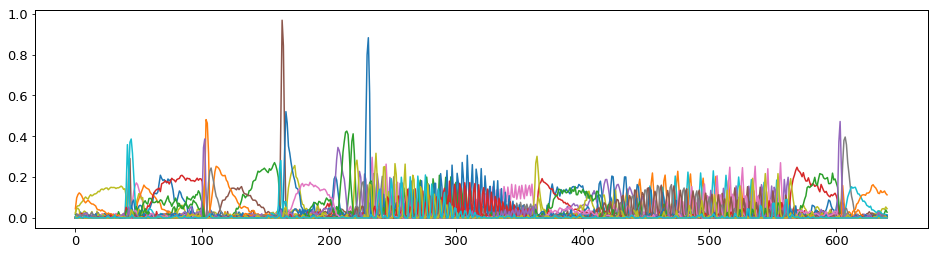

In [248]:
# Plot components
fig, ax = plt.subplots(1, 1, figsize=(16,4))

ax.plot(Vt.T)
plt.show()


## Fit various modesl w desired number of components

In [20]:
# Fit variuos models

ranks = range(1,33)#opt_model['rank'] # define rank / number of components
np.random.seed(seed=opt_model['seed']) # set rng seed to seed of best model   

model = dict() # initialize

for irank in ranks:
    print('Fitting optimal model with %i components...' %irank)
    U, Vt, tr_err, te_err = cv_pca(data, irank, nonneg=True) # fit model

    print('U: Cells and their component weights \t [n_cells x n_components] =', U.shape)
    print('Vt: Components and their time weights \t [n_componetns x n_tPoints] =', Vt.shape)

    # Check that optimal model gives same error values as original one and save model components
    #     assert format(te_err, '.15f') == format(opt_model['test_err'], '.15f')
    model['U'] = U
    model['Vt'] = Vt
    
    # Save components for plotting
    do_save = True
    if do_save:
        # Save as .mat struct to use Miro's plotting scripts
        fname = '../../../../data/nnmf_cv_model_'+str(U.shape[1])+'.mat'
        print('Saving to: ' + fname)
        sio.savemat(fname, model)    

Fitting optimal model with 1 components...
U: Cells and their component weights 	 [n_cells x n_components] = (815, 1)
Vt: Components and their time weights 	 [n_componetns x n_tPoints] = (1, 641)
Saving to: ../../../../data/nnmf_cv_model_1.mat
Fitting optimal model with 2 components...
U: Cells and their component weights 	 [n_cells x n_components] = (815, 2)
Vt: Components and their time weights 	 [n_componetns x n_tPoints] = (2, 641)
Saving to: ../../../../data/nnmf_cv_model_2.mat
Fitting optimal model with 3 components...
U: Cells and their component weights 	 [n_cells x n_components] = (815, 3)
Vt: Components and their time weights 	 [n_componetns x n_tPoints] = (3, 641)
Saving to: ../../../../data/nnmf_cv_model_3.mat
Fitting optimal model with 4 components...
U: Cells and their component weights 	 [n_cells x n_components] = (815, 4)
Vt: Components and their time weights 	 [n_componetns x n_tPoints] = (4, 641)
Saving to: ../../../../data/nnmf_cv_model_4.mat
Fitting optimal model wi

# TESTS

In [2]:
# Do dry run with artificial data generated by plot_nmf()
plot_nmf()

Fitting model with rank 1/7 ...
Fitting model with rank 2/7 ...
Fitting model with rank 3/7 ...
Fitting model with rank 4/7 ...
Fitting model with rank 5/7 ...
Fitting model with rank 6/7 ...
Fitting model with rank 7/7 ...
DONE.


In [24]:
# Parameters
# N, R = 150, 4
# noise = .8
repetitions = 2
ranks = np.arange(1, 3)

In [5]:
# Initialize problem
# U = np.random.rand(N, R)
# Vt = np.random.rand(R, N)
# data = np.dot(U, Vt) + noise*np.random.rand(N, N)
# train_err, test_err = [], []

In [25]:
# Fit NNMF models w various k components

train_err, test_err = [], [] # initialize problem

t = time.time() # get execution time
for rnk, _ in itertools.product(ranks, range(repetitions)):
    print('Fitting model with rank %i/%i ...' % (rnk, ranks[-1]))
    tr, te = cv_pca(data, rnk, nonneg=True)[2:]
    train_err.append((rnk, tr))
    test_err.append((rnk, te))
    
print('DONE! Execution time: %i s.' % round(time.time() - t))

Fitting model with rank 1/2 ...
Fitting model with rank 1/2 ...
Fitting model with rank 2/2 ...
Fitting model with rank 2/2 ...
DONE! Execution time: 91 s.


In [9]:
tr, te = cv_pca(data, 30, nonneg=True)[2:]